# **Imports**


In [2]:
%pip install --upgrade ultralytics
%pip install --upgrade torchvision --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
  Using cached ultralytics-8.2.99-py3-none-any.whl.metadata (39 kB)
Using cached ultralytics-8.2.99-py3-none-any.whl (874 kB)
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.2.98
    Uninstalling ultralytics-8.2.98:
      Successfully uninstalled ultralytics-8.2.98
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


# Classess

In [1]:
import torch
from ultralytics import YOLO
import numpy as np


class YOLOv9Classifier:
    """
    YOLOv9 Classifier with customizable architecture and hyperparameters.
    """

    def __init__(
        self,
        model_name="yolov9e.pt",
        lr=1e-3,
        lrf=0.01,
        weight_decay=5e-4,
        dropout=0.0,
        fraction=1.0,
        epochs=100,
        batch_size=4,
        device="cpu",
        optimizer_type="auto",
        patience=20,
        profile=False,
        label_smoothing=0.0,
        random_state=None,
        seed=42,
        verbose=False,
        exp_name="experiment",
        data_yaml=None,
        imgsz=(640, 640),
        task="detect",
        val=False,
        amp=True,
        exist_ok=True,
        resume=False,
        output_dir=".",
    ):
        """
        Initialize the YOLOv9 classifier with the provided architecture and hyperparameters.
        """
        self.model_name = model_name
        self.task = task
        self.lr = lr
        self.lrf = lrf
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.fraction = fraction
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device
        self.optimizer_type = optimizer_type
        self.patience = patience
        self.profile = profile
        self.label_smoothing = label_smoothing
        self.random_state = random_state
        self.verbose = verbose
        self.seed = seed
        self.exp_name = exp_name
        self.data_yaml = data_yaml
        self.imgsz = imgsz
        self.val = val
        self.amp = amp
        self.exist_ok = exist_ok
        self.resume = resume
        self.output_dir = output_dir

        self.model = YOLO(model_name)

        if random_state is not None:
            self._set_random_state(random_state)

    def _set_random_state(self, random_state):
        """
        Set the random seed for reproducibility.
        """
        np.random.seed(random_state)
        torch.manual_seed(random_state)
        if self.device == "cuda":
            torch.cuda.manual_seed_all(random_state)

    def set_params(self, **params):
        """
        Set parameters for the classifier and reinitialize the model.
        """
        for param, value in params.items():
            setattr(self, param, value)

    def fit(self):
        """
        Train the YOLOv9 model on the data. Handles both training and validation logic.
        """
        if self.data_yaml is None:
            raise ValueError("Data YAML file must be provided for YOLO training.")

        self.model.train(
            data=self.data_yaml,
            task=self.task,
            imgsz=self.imgsz,
            epochs=self.epochs,
            batch=self.batch_size,
            optimizer=self.optimizer_type,
            lr0=self.lr,
            lrf=self.lrf,
            weight_decay=self.weight_decay,
            dropout=self.dropout,
            patience=self.patience,
            fraction=self.fraction,
            profile=self.profile,
            label_smoothing=self.label_smoothing,
            name=self.exp_name,
            seed=self.seed,
            val=self.val,
            amp=self.amp,
            exist_ok=self.exist_ok,
            resume=self.resume,
            device=self.device,
            verbose=self.verbose,
            project=self.output_dir,
        )

    def evaluate(self):
        """
        Evaluate the YOLOv9 model on the validation data.
        """
        if self.data_yaml is None:
            raise ValueError("Data YAML file must be provided for YOLO evaluation.")

        metrics = self.model.val(
            data=self.data_yaml,
            imgsz=self.imgsz,
            batch=self.batch_size,
            device=self.device,
        )
        return metrics

    def predict(self, img_paths):
        """
        Predict using the YOLOv9 model on the given images.
        """
        results = self.model.predict(img_paths)
        return results

    def save_model(self, path):
        """
        Save the YOLOv9 model to the specified path.
        """
        self.model.save(path)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as patches
from IPython.display import display


class EDA:
    """
    A class to perform Exploratory Data Analysis (EDA) on image datasets, specifically for YOLO-based tasks.

    Attributes
    ----------
    yolo_loader : YOLODataLoader
        An instance of YOLODataLoader that contains 'train', 'valid', and 'test' DataLoaders.
    class_names : list
        List of class names in the YOLODataLoader.
    """

    def __init__(self, yolo_loader):
        """
        Constructs all the necessary attributes for the EDA object.

        Parameters
        ----------
        yolo_loader : YOLODataLoader
            An instance of YOLODataLoader that contains 'train', 'valid', and 'test' DataLoaders.
        """
        self.yolo_loader = yolo_loader
        self.class_names = yolo_loader.class_names

    def show_sample_images(self, num_images=6, loader_type="train"):
        """
        Displays a grid of sample images from the dataset.

        Parameters
        ----------
        num_images : int, optional
            Number of images to display (default is 6).
        loader_type : str, optional
            Specifies which DataLoader to use ('train', 'valid', 'test').
        """
        images_shown = 0
        num_cols = 3
        num_rows = (num_images + num_cols - 1) // num_cols

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

        dataloaders = self.yolo_loader.get_loaders()

        if loader_type == "train":
            dataloader = dataloaders[0]
        elif loader_type == "valid":
            dataloader = dataloaders[1]
        elif loader_type == "test":
            dataloader = dataloaders[2]
        else:
            raise ValueError("loader_type should be one of 'train', 'valid', or 'test'")

        for images, labels in dataloader:
            for i in range(len(images)):
                if images_shown >= num_images:
                    break

                row = images_shown // num_cols
                col = images_shown % num_cols
                ax = axes[row, col] if num_rows > 1 else axes[col]

                ax.imshow(images[i])
                ax.axis("off")
                self.display_bboxes_on_image(ax, labels[i], images[i])
                images_shown += 1

            if images_shown >= num_images:
                break

        for j in range(images_shown, num_rows * num_cols):
            fig.delaxes(
                axes[j // num_cols, j % num_cols]
                if num_rows > 1
                else axes[j % num_cols]
            )

        plt.tight_layout()
        plt.show()

    def display_bboxes_on_image(self, ax, label, image):
        """
        Helper function to display bounding boxes on an image.

        Parameters
        ----------
        ax : matplotlib axis
            Axis to plot on.
        label : list
            List of labels containing bounding boxes.
        image : PIL.Image
            The image to display.
        """
        if len(label) == 0:
            return

        for obj in label:
            class_idx = int(obj[0])
            x_center, y_center, width, height = obj[1:]

            x_min = (x_center - width / 2) * image.size[0]
            y_min = (y_center - height / 2) * image.size[1]
            width *= image.size[0]
            height *= image.size[1]

            rect = patches.Rectangle(
                (x_min, y_min),
                width,
                height,
                linewidth=2,
                edgecolor="r",
                facecolor="none",
            )
            ax.add_patch(rect)
            ax.text(
                x_min,
                y_min,
                self.class_names[class_idx],
                color="white",
                verticalalignment="top",
                bbox={"facecolor": "red", "alpha": 0.5, "pad": 1},
            )

    def plot_class_distribution(self):
        """
        Plots the class distribution across different dataset modes (train/val/test).
        """
        class_info = []

        train_loader, val_loader, test_loader = self.yolo_loader.get_loaders()
        dataloaders = {"train": train_loader, "valid": val_loader, "test": test_loader}

        for mode, dataloader in dataloaders.items():
            mode_class_count = {
                self.class_names[i]: 0 for i in range(len(self.class_names))
            }

            for images, labels in dataloader:
                for label in labels:
                    for obj in label:
                        class_id = int(obj[0])
                        mode_class_count[self.class_names[class_id]] += 1

            class_info.append({**mode_class_count, "Mode": mode})

        dataset_stats_df = pd.DataFrame(class_info)

        fig, axes = plt.subplots(1, len(dataloaders), figsize=(15, 5))
        for i, (mode, dataloader) in enumerate(dataloaders.items()):
            sns.barplot(
                data=dataset_stats_df[dataset_stats_df["Mode"] == mode].drop(
                    columns="Mode"
                ),
                orient="v",
                ax=axes[i],
                palette="Set2",
            )
            axes[i].set_title(f"{mode.capitalize()} Class Statistics")
            axes[i].set_xlabel("Classes")
            axes[i].set_ylabel("Count")
            axes[i].tick_params(axis="x", rotation=90)

        plt.tight_layout()
        plt.show()

    def display_image_by_index(self, idx, loader_type="train"):
        """
        Displays a specific image by its index in the dataloader with bounding boxes.

        Parameters
        ----------
        idx : int
            Index of the image to display.
        loader_type : str
            Specifies which DataLoader to use ('train', 'valid', 'test').
        """
        img, label = None, None
        count = 0
        dataloaders = self.yolo_loader.get_loaders()
        dataloader = dataloaders[loader_type]

        for imgs, labels in dataloader:
            for i in range(len(imgs)):
                if count == idx:
                    img, label = imgs[i], labels[i]
                    break
                count += 1
            if img is not None:
                break

        if img is not None:
            fig, ax = plt.subplots(1)
            ax.imshow(img)
            ax.axis("off")
            self.display_bboxes_on_image(ax, label, img)
            plt.show()
        else:
            print(f"Index {idx} is out of range.")

    def show_dataset_statistics(self):
        """
        Displays class statistics for train/valid/test datasets.
        """
        class_info = []

        train_loader, val_loader, test_loader = self.yolo_loader.get_loaders()
        dataloaders = {"train": train_loader, "valid": val_loader, "test": test_loader}

        for mode, dataloader in dataloaders.items():
            mode_class_count = {
                self.class_names[i]: 0 for i in range(len(self.class_names))
            }

            for images, labels in dataloader:
                for label in labels:
                    for obj in label:
                        class_id = int(obj[0])
                        mode_class_count[self.class_names[class_id]] += 1

            class_info.append({**mode_class_count, "Mode": mode})

        dataset_stats_df = pd.DataFrame(class_info)
        display(dataset_stats_df)


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import yaml


class YOLODataLoader:
    """
    Custom DataLoader class for loading YOLO formatted data (images and labels)
    and returning a DataLoader directly.

    Attributes
    ----------
    train_dir : str
        Path to the directory containing train images and labels.
    val_dir : str
        Path to the directory containing validation images and labels.
    test_dir : str
        Path to the directory containing test images and labels.
    batch_size : int
        The number of samples in each batch.
    shuffle : bool
        Whether to shuffle the dataset.
    """

    def __init__(
        self,
        train_dir,
        val_dir,
        test_dir,
        yaml_path=None,
        batch_size=8,
        shuffle=True,
    ):
        """
        Parameters
        ----------
        train_dir : str
            Directory containing the train images and labels.
        val_dir : str
            Directory containing the validation images and labels.
        test_dir : str
            Directory containing the test images and labels.
        yaml_path : str, optional
            Path to the YAML file with class names and other metadata.
        batch_size : int, optional
            The number of samples in each batch (default is 8).
        shuffle : bool, optional
            Whether to shuffle the dataset (default is True).
        """
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.train_image_dir = os.path.join(train_dir, "images")
        self.train_label_dir = os.path.join(train_dir, "labels")

        self.val_image_dir = os.path.join(val_dir, "images")
        self.val_label_dir = os.path.join(val_dir, "labels")

        self.test_image_dir = os.path.join(test_dir, "images")
        self.test_label_dir = os.path.join(test_dir, "labels")

        self.class_names = self.load_yaml_classes(yaml_path) if yaml_path else []

        # Create datasets
        self.train_dataset = YOLODataset(self.train_image_dir, self.train_label_dir)
        self.val_dataset = YOLODataset(self.val_image_dir, self.val_label_dir)
        self.test_dataset = YOLODataset(self.test_image_dir, self.test_label_dir)

        # Create DataLoaders
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            collate_fn=self.collate_fn,
        )
        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )
        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

    def get_loaders(self):
        """
        Returns train, val, and test DataLoader instances.
        """
        return self.train_loader, self.val_loader, self.test_loader

    def load_yaml_classes(self, yaml_path):
        """
        Loads class names from a YAML file.

        Parameters
        ----------
        yaml_path : str
            Path to the YAML file containing class information.

        Returns
        -------
        class_names : list
            List of class names from the YAML file.
        """
        if not os.path.exists(yaml_path):
            raise FileNotFoundError(f"YAML file not found at {yaml_path}")

        with open(yaml_path, "r") as file:
            data = yaml.safe_load(file)

        class_names = data.get("names", [])

        if not class_names:
            raise ValueError("No class names found in the YAML file.")

        print(f"Classes loaded: {class_names}")
        return class_names

    @staticmethod
    def collate_fn(batch):
        """
        Custom collate function to handle variable size labels (for YOLO formatted data).
        """
        images, labels = zip(*batch)
        return list(images), list(labels)

    def update_yaml_paths(self, yaml_path, output_yaml_path):
        """
        Update paths in the YAML file with the correct paths of the train, val, and test directories.

        Parameters
        ----------
        yaml_path : str
            Path to the original YAML file.
        output_yaml_path : str
            Path to save the updated YAML file with new paths for train, val, and test.
        """
        with open(yaml_path, "r") as file:
            data = yaml.safe_load(file)

        # Update the paths for train, val, and test with absolute paths
        data["train"] = os.path.abspath(os.path.join(self.train_dir, "images"))
        data["val"] = os.path.abspath(os.path.join(self.val_dir, "images"))
        data["test"] = os.path.abspath(os.path.join(self.test_dir, "images"))

        with open(output_yaml_path, "w") as file:
            yaml.safe_dump(data, file)

        print(f"YAML paths updated and saved to {output_yaml_path}")
        return output_yaml_path


class YOLODataset(Dataset):
    """
    Dataset class for loading YOLO formatted data (images and labels).
    """

    def __init__(self, image_dir, label_dir):
        """
        Parameters
        ----------
        image_dir : str
            Directory containing the images.
        label_dir : str
            Directory containing the labels.
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_filenames = [
            f
            for f in os.listdir(self.image_dir)
            if f.endswith((".png", ".jpg", ".jpeg"))
        ]

    def __len__(self):
        """Returns the total number of image files."""
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Fetches an image and its corresponding label.

        Parameters
        ----------
        idx : int
            Index of the image file.

        Returns
        -------
        image : PIL.Image
            The image in PIL format.
        label : list
            List of labels (bounding boxes and classes) for the image.
        """
        img_filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        image = Image.open(img_path).convert("RGB")

        # Load the corresponding label
        label_filename = (
            img_filename.replace(".png", ".txt")
            .replace(".jpg", ".txt")
            .replace(".jpeg", ".txt")
        )
        label_path = os.path.join(self.label_dir, label_filename)

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label_data = f.readlines()
            label = [list(map(float, line.strip().split())) for line in label_data]
        else:
            label = []

        return image, label


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from PIL import Image
from IPython.display import display


class YOLOEvaluator:
    """
    A class to evaluate and display YOLO model performance results for object detection tasks.
    """

    def __init__(self, full_output_dir):
        """
        Initialize the evaluator with the paths where model outputs are stored.

        Parameters
        ----------
        output_dir : str
            Directory where the model outputs are saved.
        exp_name : str
            Experiment name or folder where model results are stored.
        """
        self.full_output_dir = full_output_dir
        self.log_path = f"{self.full_output_dir}/results.csv"

    def load_training_logs(self):
        """
        Load the training logs from the CSV file.

        Returns
        -------
        df : pandas.DataFrame
            The DataFrame containing the training logs.
        """
        df = pd.read_csv(self.log_path)
        df = df.rename(columns=lambda x: x.replace(" ", ""))
        return df

    def display_results(
        self,
        best_models,
        best_params,
        best_scores,
        best_model_name,
        help_text=False,
    ):
        """
        Displays the evaluation metrics for the best models and their parameters using the logs.
        """
        df = self.load_training_logs()

        final_results = df.iloc[-1]

        results = [
            {
                "Model": best_model_name,
                "Precision": final_results.get("metrics/precision(B)", "N/A"),
                "Recall": final_results.get("metrics/recall(B)", "N/A"),
                "mAP 50": final_results.get("metrics/mAP50(B)", "N/A"),
                "mAP 50-95": final_results.get("metrics/mAP50-95(B)", "N/A"),
                "Validation Box Loss": final_results.get("val/box_loss", "N/A"),
                "Validation Cls Loss": final_results.get("val/cls_loss", "N/A"),
                "Validation DFL Loss": final_results.get("val/dfl_loss", "N/A"),
            }
        ]

        results_df = pd.DataFrame(results)

        param_df = (
            pd.DataFrame(best_params).T.reset_index().rename(columns={"index": "Model"})
        )
        best_model_df = pd.DataFrame(
            {
                "Overall Best Model": [best_model_name],
                "Score (mAP 50-95)": [best_scores.get(best_model_name, "N/A")],
            }
        )

        print("Evaluation Metrics for Test Set:")
        display(results_df)

        print("\nBest Parameters for Each Model (found during hyperparameter tuning):")
        display(param_df)

        print("\nOverall Best Model and Score (based on validation mAP):")
        display(best_model_df)

        if help_text:
            print("\nMetric Explanations for Object Detection:")
            print("Box Loss: Localization loss (bounding box).")
            print("Cls Loss: Classification loss (object type).")
            print("DFL Loss: Distribution Focal Loss.")
            print("Precision: Ratio of correctly predicted positives.")
            print("Recall: Ratio of correctly predicted actual positives.")
            print("mAP 50: Mean Average Precision at IoU threshold 0.5.")
            print(
                "mAP 50-95: Mean Average Precision across IoU thresholds 0.5 to 0.95."
            )

    def display_predictions(self, num_columns=3):
        """
        Display predicted images from the model's output folder in a grid.

        Parameters
        ----------
        num_columns : int
            Number of columns for displaying images in a grid.
        """
        results_paths = [
            i
            for i in glob.glob(f"{self.full_output_dir}/*.png")
            + glob.glob(f"{self.full_output_dir}/*.jpg")
            if "batch" not in i
        ]
        results_paths = sorted(results_paths)

        if len(results_paths) == 0:
            print(f"No results found in the directory: {self.full_output_dir}")
            return

        print(
            f"Displaying {len(results_paths)} prediction images from {self.full_output_dir}:"
        )
        num_rows = len(results_paths) // num_columns + int(
            len(results_paths) % num_columns > 0
        )

        fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
        axes = axes.flatten()

        for i, file in enumerate(results_paths):
            img = Image.open(file)
            axes[i].imshow(img)
            axes[i].axis("off")

        for j in range(i + 1, num_rows * num_columns):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

    def plot_training_metrics(self):
        """
        Plot the training and validation metrics for the model.
        """
        df = self.load_training_logs()

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

        ax1.set_title("Box Loss")
        ax1.plot(
            df["epoch"],
            df["train/box_loss"],
            label="Training box_loss",
            marker="o",
            linestyle="-",
        )
        ax1.plot(
            df["epoch"],
            df["val/box_loss"],
            label="Validation box_loss",
            marker="o",
            linestyle="-",
        )
        ax1.set_ylabel("Box Loss")
        ax1.legend()
        ax1.grid(True)

        ax2.set_title("Cls Loss")
        ax2.plot(
            df["epoch"],
            df["train/cls_loss"],
            label="Training cls_loss",
            marker="o",
            linestyle="-",
        )
        ax2.plot(
            df["epoch"],
            df["val/cls_loss"],
            label="Validation cls_loss",
            marker="o",
            linestyle="-",
        )
        ax2.set_ylabel("Cls Loss")
        ax2.legend()
        ax2.grid(True)

        ax3.set_title("DFL Loss")
        ax3.plot(
            df["epoch"],
            df["train/dfl_loss"],
            label="Training dfl_loss",
            marker="o",
            linestyle="-",
        )
        ax3.plot(
            df["epoch"],
            df["val/dfl_loss"],
            label="Validation dfl_loss",
            marker="o",
            linestyle="-",
        )
        ax3.set_xlabel("Epochs")
        ax3.set_ylabel("DFL Loss")
        ax3.legend()
        ax3.grid(True)

        plt.suptitle("Training Metrics vs. Epochs")
        plt.show()

    def plot_map_history(self):
        """
        Plot the mAP 50 and mAP 50-95 history of the YOLO model from logs.
        """
        df = self.load_training_logs()

        plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50")
        plt.plot(
            df["epoch"],
            df["metrics/mAP50-95(B)"],
            label="mAP@50:95",
            color="orange",
        )
        plt.title("mAP@50 and mAP@50:95 over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("mAP")
        plt.legend()
        plt.grid(True)
        plt.show()


In [ ]:
from sklearn.model_selection import ParameterGrid
import os


class YOLOv9Trainer:
    """
    A class to train YOLOv9 models with manual hyperparameter tuning.
    Supports object detection tasks.
    """

    def __init__(self, device="cpu"):
        """
        Initialize the trainer with a device.
        """
        self.device = device
        self.best_estimators = {}
        self.best_params = {}
        self.best_scores = {}
        self.best_model_name = None
        self.best_model_score = float("-inf")
        self.best_model_path = None

    def train(self, models, param_grids, output_base_dir="./results"):
        """
        Train the YOLOv9 models using manual hyperparameter tuning.

        Parameters
        ----------
        models : dict
            Dictionary of models to be trained.
        param_grids : dict
            Dictionary containing parameter grids for each model.
        output_base_dir : str
            Base directory to store output results.
        """
        print(f"Training on device: {self.device}")

        total_iterations = 0
        for model_name, model in models.items():
            param_combinations = list(ParameterGrid(param_grids[model_name]))
            total_iterations += sum([params["epochs"] for params in param_combinations])

        experiment_count = 1

        for model_name, model in models.items():
            param_grid = param_grids[model_name]
            param_combinations = list(ParameterGrid(param_grid))

            for params in param_combinations:
                exp_name = f"{model_name}_experiment_{experiment_count}"

                exp_output_dir = os.path.join(output_base_dir, exp_name)
                if not os.path.exists(exp_output_dir):
                    os.makedirs(exp_output_dir)

                print(
                    f"\nTraining {model_name} with parameters: {params}, saving to {exp_output_dir}"
                )

                model.set_params(
                    **params, output_dir=output_base_dir, exp_name=exp_name
                )

                model.fit()

                metrics = model.evaluate()

                score = metrics.box.map

                self.best_scores[model_name] = score

                if score > self.best_model_score:
                    self.best_model_name = model_name
                    self.best_model_score = score
                    self.best_estimators[model_name] = model
                    self.best_params[model_name] = params
                    self.best_model_path = exp_output_dir

                experiment_count += 1

        print(
            f"\nBest Model: {self.best_model_name} with score: {self.best_model_score}"
        )
        print(f"Best model saved at: {self.best_model_path}")


In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print(torch.version.cuda)

print(torch.cuda.is_available())

2.4.1+cu118
0.19.1+cu118
11.8
True


# **Data Load**


In [3]:
yolo_loader = YOLODataLoader(
    train_dir="./db/train",
    val_dir="./db/valid",
    test_dir="./db/test",
    yaml_path="./db/data.yaml",
    batch_size=8,
    shuffle=True,
)

Classes loaded: ['door', 'cabinetDoor', 'refrigeratorDoor', 'window', 'chair', 'table', 'cabinet', 'couch', 'openedDoor', 'pole']


In [4]:
updated_yaml_path = yolo_loader.update_yaml_paths(
    yaml_path="./db/data.yaml",
    output_yaml_path="./db/updated_data.yaml",
)

YAML paths updated and saved to ./db/updated_data.yaml


In [5]:
print(f"Yolo DataLoader type: {type(yolo_loader)}")
print(f"Updated YAML path: {updated_yaml_path}")

Yolo DataLoader type: <class 'tools.YOLODataLoader.YOLODataLoader'>
Updated YAML path: ./db/updated_data.yaml


# **EDA**


In [6]:
eda = EDA(yolo_loader)

In [7]:
eda.show_dataset_statistics()

,door,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,openedDoor,pole,Mode
0,473,3178,689,403,204,228,179,27,78,27,train
1,96,765,192,91,49,40,32,1,13,9,valid
2,34,179,2,63,87,47,52,58,20,8,test


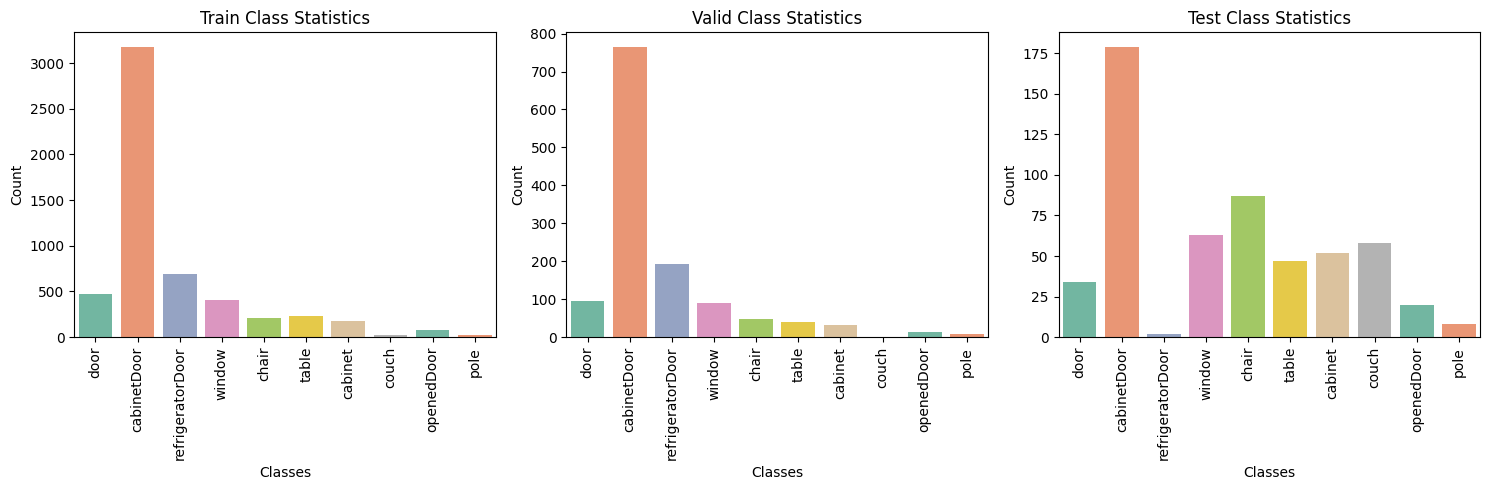

In [8]:
eda.plot_class_distribution()

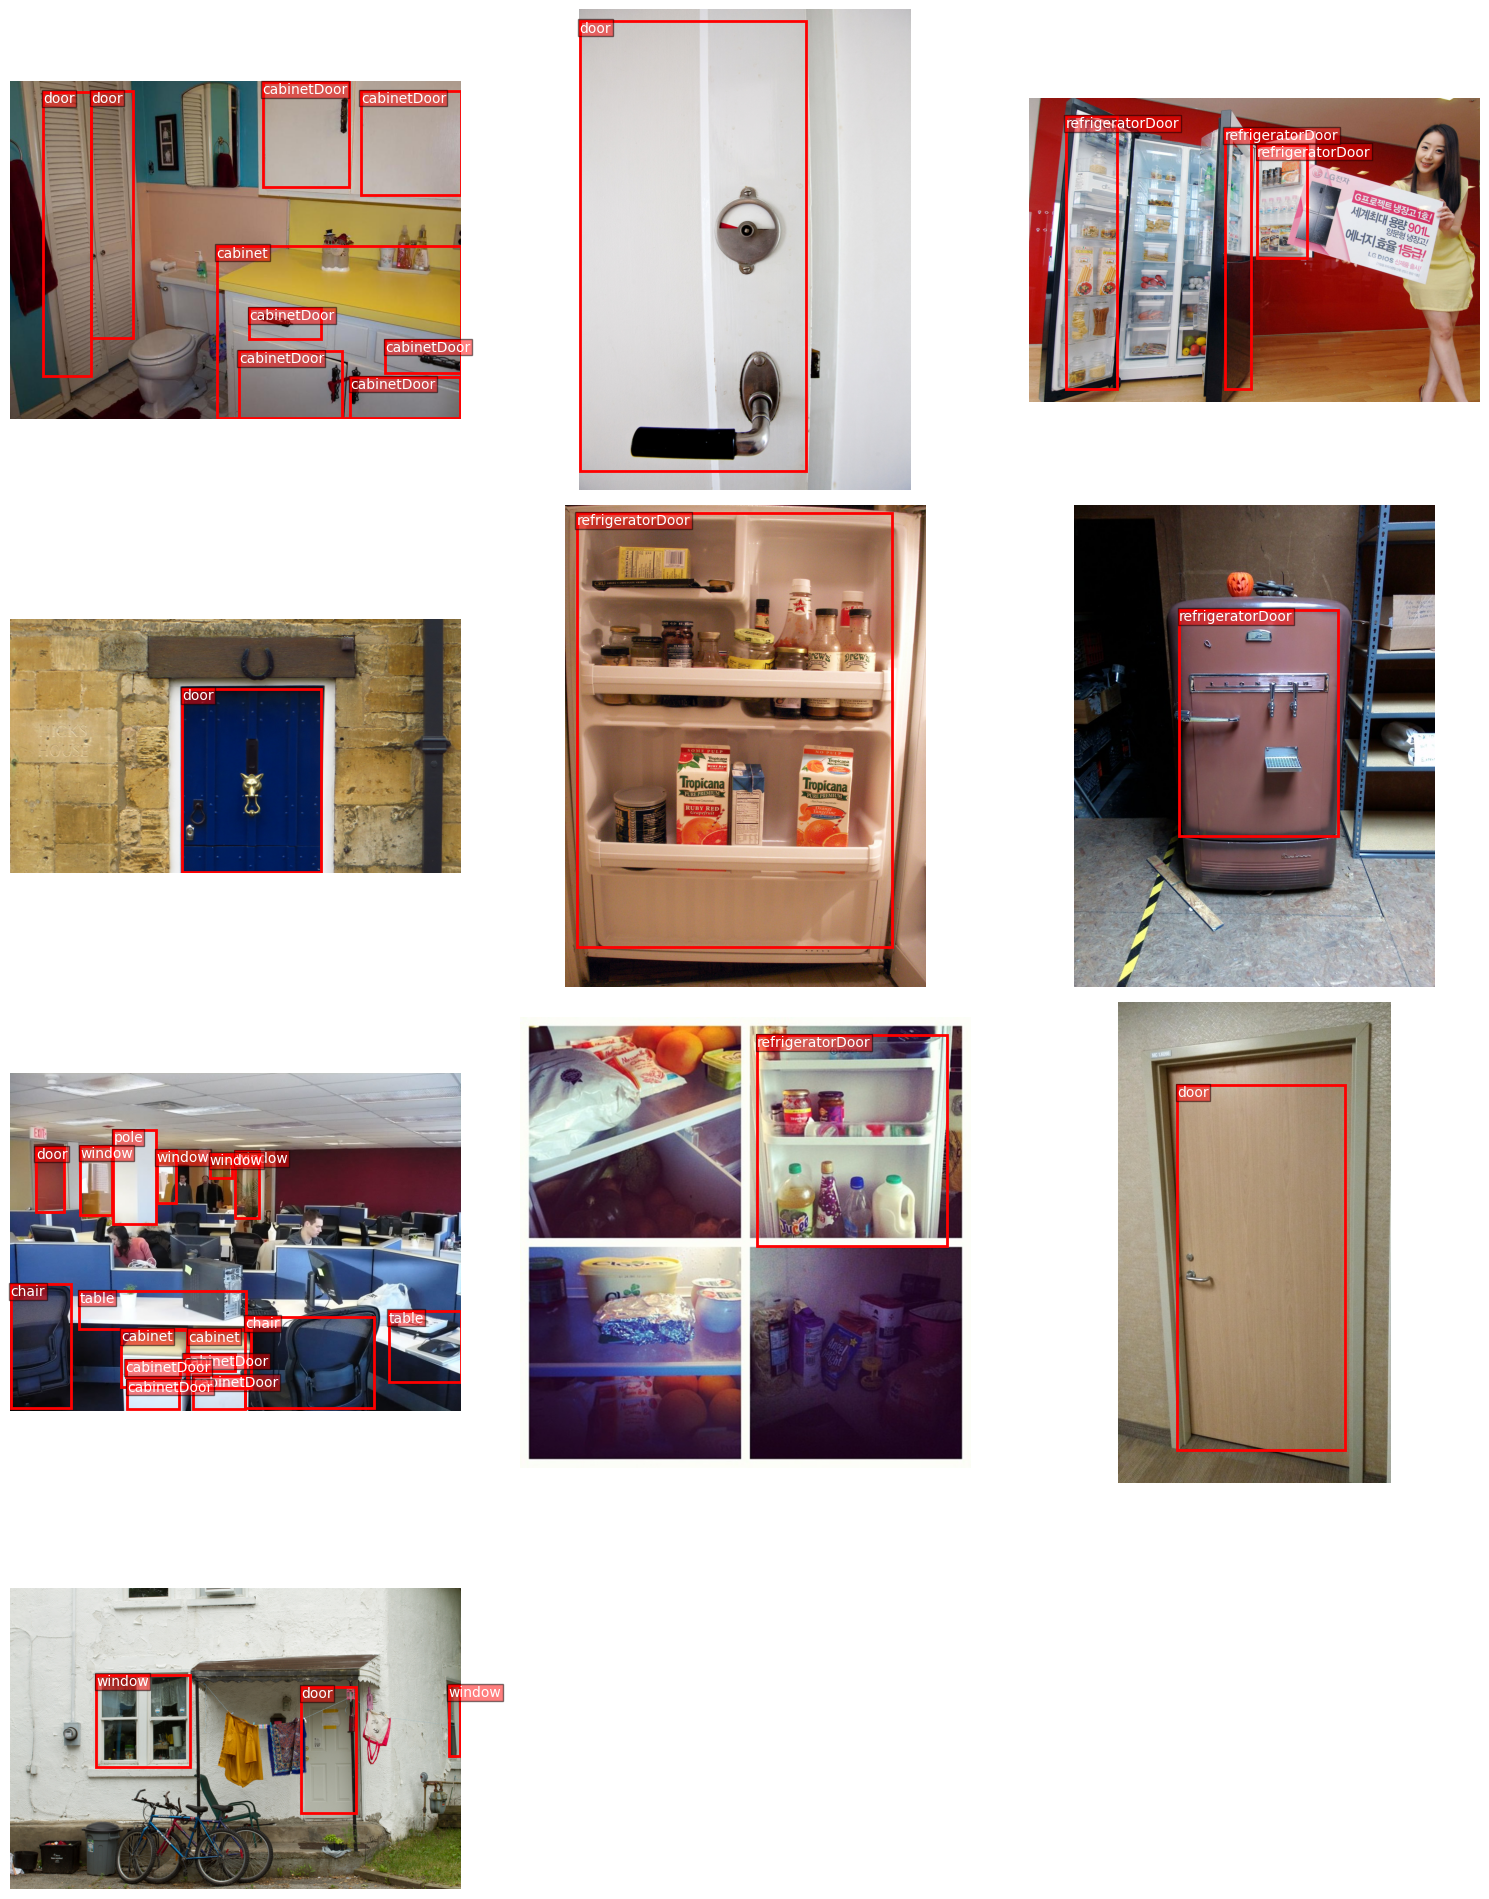

In [9]:
eda.show_sample_images(num_images=10, loader_type="train")

# **Modal Initialization**


In [10]:
yolo_model = YOLOv9Classifier(
    data_yaml=updated_yaml_path,
    task="detect",
    imgsz=(640, 640),
    model_name="yolov9e.pt",
    device="cuda",
    random_state=42,
    profile=False,
    val=True,
    amp=True,
    exist_ok=True,
    resume=False,
    verbose=True,
)

In [11]:
param_grid = {
    "epochs": [50],
    "batch_size": [8],
    "optimizer_type": ["auto"],
    "lr": [1e-3],
    "lrf": [0.01],
    "patience": [20],
    "weight_decay": [5e-4],
    "dropout": [0.0],
    "fraction": [1.0],
    "label_smoothing": [0.0],
}

In [12]:
models = {"yolo_model": yolo_model}
param_grids = {"yolo_model": param_grid}

# **Model Training**


In [13]:
trainer = YOLOv9Trainer(device="cuda")

In [14]:
trainer.train(models=models, param_grids=param_grids, output_base_dir="./res")

Training on device: cuda

Training yolo_model with parameters: {'batch_size': 4, 'dropout': 0.0, 'epochs': 3, 'fraction': 0.8, 'label_smoothing': 0.0, 'lr': 0.001, 'lrf': 0.01, 'optimizer_type': 'auto', 'patience': 20, 'weight_decay': 0.0005}, saving to ./res\yolo_model_experiment_1
Ultralytics YOLOv8.2.98  Python-3.12.3 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov9e.pt, data=./db/updated_data.yaml, epochs=3, time=None, patience=20, batch=4, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=cuda, workers=8, project=./res, name=yolo_model_experiment_1, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.8, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0

train: Scanning C:\Users\Acer\Documents\GitHub\goit-cv-hw8\src\db\train\labels... 807 images, 78 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<00:00, 2036.91it/s]

train: New cache created: C:\Users\Acer\Documents\GitHub\goit-cv-hw8\src\db\train\labels.cache



val: Scanning C:\Users\Acer\Documents\GitHub\goit-cv-hw8\src\db\valid\labels.cache... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]


Plotting labels to res\yolo_model_experiment_1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to res\yolo_model_experiment_1
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/203 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 600.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 220.75 MiB is free. Of the allocated memory 2.91 GiB is allocated by PyTorch, and 74.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [26]:
best_models = trainer.best_estimators
best_params = trainer.best_params
best_scores = trainer.best_scores
best_model_name = trainer.best_model_name
best_model = best_models[best_model_name]
best_model_path = trainer.best_model_path

In [27]:
print(best_models)
print(best_params)
print(best_scores)
print(best_model_name)
print(best_model)
print(best_model_path)

{'cnn_model': <models.PyTorchCNNClassifier.PyTorchCNNClassifier object at 0x000002345AF647D0>}
{'cnn_model': {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 10, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'AvgPool2d', 'pool_kernel_size': 2, 'pool_padding': 1, 'pool_stride': 2}}
{'cnn_model': 0.781744335185977}
cnn_model


# **Model Evaluator**


In [28]:
evaluator = YOLOEvaluator(full_output_dir=best_model_path)

In [30]:
evaluator.display_results(
    best_models=best_models,
    best_params=best_params,
    best_scores=best_scores,
    best_model_name=best_model_name,
    help_text=True,
)

Validation Loss: 0.43439963827791445, Validation Accuracy: 0.836
Evaluation Metrics for Test Set:


,Model,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
0,cnn_model,0.836,0.839186,0.83615,0.841536,0.836



Best Parameters for Each Model (found during hyperparameter tuning):


,Model,activation_fn,batch_size,conv_layers,dropout_rate,epochs,hidden_sizes,lr,optimizer_type,pool_fn,pool_kernel_size,pool_padding,pool_stride
0,cnn_model,ReLU,16,"[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]",0.1,10,"[256, 128]",0.001,adam,AvgPool2d,2,1,2



Overall Best Model and Score (based on cross-validation score):


,Overall Best Model,Score (based on cross-validation score)
0,cnn_model,0.781744



Metric Explanations for Classification:
Accuracy: The ratio of correctly predicted instances to the total instances.
Balanced Accuracy: The average of recall obtained on each class.
F1 Score: Harmonic mean of precision and recall.
Precision: Ratio of correctly predicted positive observations to all positive predictions.
Recall: Ratio of correctly predicted positive observations to all actual positives.


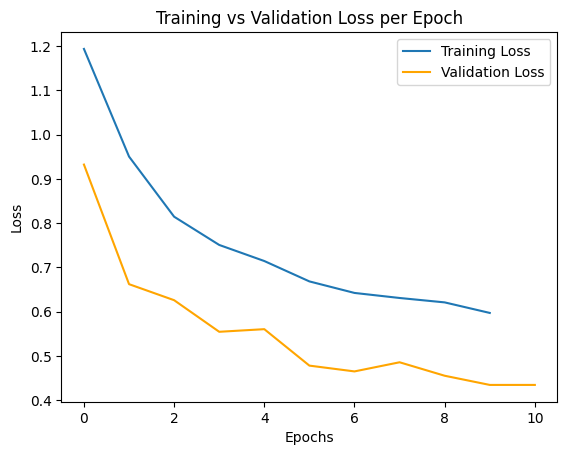

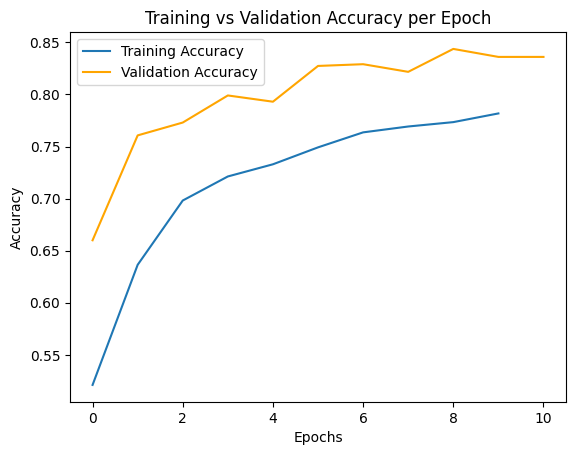

In [31]:
evaluator.display_predictions(num_columns=3)

In [ ]:
evaluator.plot_training_metrics()

In [ ]:
evaluator.plot_map_history()

# **Key Conclusions:**


# Model Performance:

The model (yolo_model) achieved a precision of 0.6707 and a recall of 0.2949, indicating that while the model is fairly good at correctly identifying positives (high precision), it struggles with recalling many true positives (low recall).

The mean Average Precision (mAP) at 50% IoU is 0.3628, showing moderate performance on easier thresholds for object detection.

However, the mAP 50-95 (stricter thresholds) is much lower at 0.2134, indicating that the model struggles to generalize well across varying IoU thresholds.

# Validation Losses:

The Box Loss is 1.8559, reflecting the localization error between predicted and ground truth bounding boxes.

The Classification Loss is quite high at 2.3873, which suggests that the model is finding it difficult to accurately classify objects.

The DFL (Distribution Focal Loss) is 1.9339, which affects the precision of the bounding box regression. This value shows the room for improvement in how well the model is predicting the exact bounding box locations.

# Hyperparameters:

The best hyperparameters found during tuning are:

Batch size: 8

Dropout: 0.0

Epochs: 50

Fraction: 1.0 (all data used)

Label smoothing: 0.0

Learning rate (lr): 0.001

Learning rate factor (lrf): 0.01

Optimizer: Auto

Patience: 20

Weight decay: 0.0005

# Overall Best Model:

The best performing model in terms of validation mAP (50-95) is yolo_model, with a score of 0.2161. This is relatively low, showing that there's room for further improvement in detecting objects across different IoU thresholds.

# Recommendations:

Increase Recall: The recall is notably low, meaning the model misses many objects. It could benefit from further tuning to improve the balance between precision and recall.

Improve Classification: Given the high classification loss, adjusting class weights or experimenting with different regularization techniques (like increasing dropout) might help.
Fine-tune Learning Rate: Although a learning rate of 0.001 performed decently, further exploration of smaller or dynamic learning rates might yield better results.

More Epochs: Since the model hasn't converged well within the 50 epochs, extending training time or using a learning rate scheduler could improve performance.

Consider Data Augmentation: Adding more diverse data augmentation techniques could help improve the generalization and mAP at higher IoU thresholds.